# Dependencies

In [1]:
# Core
import os
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report
)

# Models
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Warnings
import warnings
warnings.filterwarnings("ignore")


# Data Cleaning and Preprocessing 

In [2]:
def load_and_clean_dataset_auto(file_path, spam_values=None, not_spam_values=None):
    """
    Automatically load and preprocess a dataset into ['text', 'label'] (0=ham, 1=spam).
    Detects text and label columns heuristically.
    Handles CSV encoding issues automatically.
    """
    # Detect extension
    ext = os.path.splitext(file_path)[-1].lower()

    # Load file
    if ext == ".csv":
        try:
            df = pd.read_csv(file_path, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding="latin1")
    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(file_path)
    elif ext == ".json":
        try:
            df = pd.read_json(file_path, lines=True)
        except:
            df = pd.read_json(file_path)
    elif ext == ".txt":
        try:
            df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "label"], engine="python", encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "label"], engine="python", encoding="latin1")
    else:
        raise ValueError(f"Unsupported file format: {ext}")

    # Normalize column names
    df.columns = [str(c).lower() for c in df.columns]

    # Detect text column
    obj_cols = df.select_dtypes(include="object").columns.tolist()
    if obj_cols:
        # Choose the column with longest average string length
        text_col = df[obj_cols].apply(lambda x: x.str.len().mean()).idxmax()
    else:
        # fallback: take first column
        text_col = df.columns[0]

    # Detect label column: pick column with fewest unique values excluding text_col
    possible_label_cols = [c for c in df.columns if c != text_col]
    if possible_label_cols:
        label_col = df[possible_label_cols].nunique().idxmin()
    else:
        # fallback: second column or the same as text
        label_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

    # Select and rename
    df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
    df["text"] = df["text"].astype(str)

    # Default spam/ham values
    if spam_values is None:
        spam_values = ["spam", "1", 1, True, "yes", "true", "positive"]
    if not_spam_values is None:
        not_spam_values = ["ham", "0", 0, False, "no", "false", "negative", "not spam"]

    # Normalize labels
    df["label"] = df["label"].astype(str).str.lower().map(
        lambda x: 1 if x in [str(v).lower() for v in spam_values]
        else (0 if x in [str(v).lower() for v in not_spam_values] else None)
    )

    # Drop unknown labels
    df = df.dropna(subset=["label"])
    df["label"] = df["label"].astype(int)

    # Clean text
    def clean_text(t):
        t = t.lower()
        t = re.sub(r"http\S+|www\S+", " ", t)
        t = re.sub(r"[^a-z0-9\s]", " ", t)
        t = re.sub(r"\s+", " ", t).strip()
        return t

    df["text"] = df["text"].apply(clean_text)

    return df.reset_index(drop=True)


# Data Combination

In [3]:
# Auto-detecting function
df1 = load_and_clean_dataset_auto("/kaggle/input/email-spam-or-not-classification/spam_dataset.csv")
df2 = load_and_clean_dataset_auto("/kaggle/input/190k-spam-ham-email-dataset-for-classification/spam_Emails_data.csv")
df3 = load_and_clean_dataset_auto("/kaggle/input/email-hamspam-dataset/email_spam.csv")
df4 = load_and_clean_dataset_auto("/kaggle/input/email-spam-classification-dataset-csv/emails.csv")
df5 = load_and_clean_dataset_auto("/kaggle/input/spam-email-classification/email_classification_dataset.csv")
df6 = load_and_clean_dataset_auto("/kaggle/input/spam-email-dataset/emails.csv")
df7 = load_and_clean_dataset_auto("/kaggle/input/spam-emails/spam.csv")
df8 = load_and_clean_dataset_auto("/kaggle/input/spamemailsdataset/Spam.csv")
df9 = load_and_clean_dataset_auto("/kaggle/input/spam-filter/emails.csv")
df10 = load_and_clean_dataset_auto("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")
df11 = load_and_clean_dataset_auto("/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
df12 = load_and_clean_dataset_auto("/kaggle/input/email-spam-classification/email_spam.csv")
df13 = load_and_clean_dataset_auto("/kaggle/input/email-spam-or-not-classification/spam_dataset.csv")
df14 = load_and_clean_dataset_auto("/kaggle/input/maildataset/mail_data.csv")



In [4]:
# Merge into one dataset
final_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14], ignore_index=True)

print(final_df.head())
print(final_df["label"].value_counts())

                                                text  label
0  hello lonnie just wanted to touch base regardi...      0
1  congratulations you ve won a prize call us now...      1
2  you have been pre approved for a credit card w...      1
3  limited time offer act now only a few spots le...      1
4  your loan has been approved transfer funds tod...      1
label
0    148947
1    103007
Name: count, dtype: int64


In [5]:
final_df.shape

(251954, 2)

In [6]:
final_df.isna().sum()

text     0
label    0
dtype: int64

In [7]:
final_df.duplicated().sum()

35433

In [8]:
final_df = final_df.drop_duplicates()

In [9]:
final_df.shape

(216521, 2)

In [10]:
final_dff = final_df.copy()

In [11]:
final_dff.sample(10)

,text,label
78373,author kai date escapenumber escapenumber esca...,0
145850,imbalances i would like us to continue to purs...,0
244151,url url date not supplied homeland alert is an...,0
180435,looks good need find different version code co...,0
126325,is your mortgage rate higher than escapenumber...,1
107389,we have received an executed financial master ...,0
100342,at lorraine s request i ve taken a first crack...,0
199942,st andre virgil s cream,0
118861,hey dude check basicly date site doesnt cost a...,1
168606,dear kim received email valued customer platts...,0


# Data Slicing

In [12]:


# Shuffle indices
indices = np.arange(len(final_dff))
np.random.shuffle(indices)

# Reserve 20% as hold-out
holdout_size = int(0.2 * len(final_dff))
holdout_idx = indices[:holdout_size]
train_idx   = indices[holdout_size:]

# Split into hidden test (hold-out) and training pool
df_holdout   = final_dff.iloc[holdout_idx]
df_train_all = final_dff.iloc[train_idx]


In [13]:
df_train_all.shape

(173217, 2)

# Data Visualization

Label counts:
 label
0    98116
1    75101
Name: count, dtype: int64


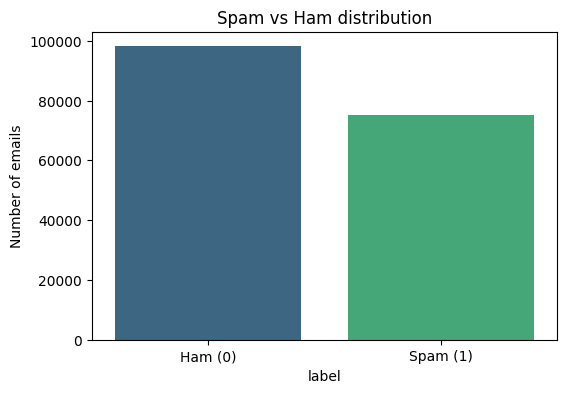

Percentage distribution:
 label
0    56.64
1    43.36
Name: count, dtype: float64


In [14]:


# Count of labels
label_counts = df_train_all['label'].value_counts()

print("Label counts:\n", label_counts)

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.ylabel("Number of emails")
plt.title("Spam vs Ham distribution")
plt.show()

# Optional: percentage
percentages = (label_counts / label_counts.sum() * 100).round(2)
print("Percentage distribution:\n", percentages)


# Over Sampling

In [15]:
import numpy as np

# Separate classes
df_ham = df_train_all[df_train_all['label'] == 0]
df_spam = df_train_all[df_train_all['label'] == 1]

# Find how many to duplicate
if len(df_ham) > len(df_spam):
    diff = len(df_ham) - len(df_spam)
    df_spam_oversampled = pd.concat([df_spam, df_spam.sample(diff, replace=True, random_state=42)])
    df_balanced = pd.concat([df_ham, df_spam_oversampled])
else:
    diff = len(df_spam) - len(df_ham)
    df_ham_oversampled = pd.concat([df_ham, df_ham.sample(diff, replace=True, random_state=42)])
    df_balanced = pd.concat([df_ham_oversampled, df_spam])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
new_counts = df_balanced['label'].value_counts()
new_percent = (new_counts / new_counts.sum() * 100).round(2)
print("Balanced label counts:\n", new_counts)
print("Balanced percentage distribution:\n", new_percent)


Balanced label counts:
 label
1    98116
0    98116
Name: count, dtype: int64
Balanced percentage distribution:
 label
1    50.0
0    50.0
Name: count, dtype: float64


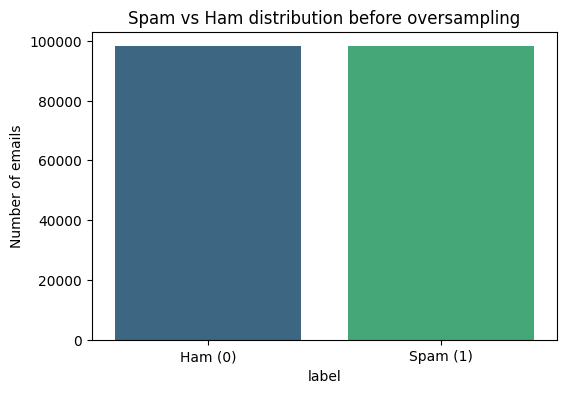

In [16]:
# Original label distribution
label_counts = df_balanced['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.ylabel("Number of emails")
plt.title("Spam vs Ham distribution before oversampling")
plt.show()


In [37]:
df_balanced.head(10)

,text,label
0,focus oem retail box microsoft adobe macromedi...,1
1,dear sirs aegis capital group llc aegis is a s...,1
2,after careful consideration our team of expert...,1
3,suprise her with how long you can last http id...,1
4,downloadable software ds is a fast growing com...,1
5,subject language separatism linguist vol6 955 ...,0
6,fyis pnm verbally promised pay back escapenumb...,0
7,would you want inexpensive perscriptions http ...,1
8,effect abundant hydro power gas market find zi...,0
9,happy holidays everyone the career centers hol...,0


# Vectorization

In [17]:
# Features and labels
X_text = df_balanced['text']
y = df_balanced['label']

# Split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print("Vectorization done. Train shape:", X_train.shape)


Vectorization done. Train shape: (156985, 5000)


## XG

In [18]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)




XGBoost Metrics:
Accuracy: 0.9627232654725202
Precision: 0.9467624483369416
Recall: 0.9805840085613821
F1 Score: 0.9633764738278219
Confusion Matrix:
 [[18542  1082]
 [  381 19242]]


In [31]:
# Predictions
y_pred_xgb = xgb_model.predict(X_train)

# Evaluation
print("SVM Metrics:")
print("Accuracy:", accuracy_score(y_train, y_pred_xgb))
print("Precision:", precision_score(y_train, y_pred_xgb))
print("Recall:", recall_score(y_train, y_pred_xgb))
print("F1 Score:", f1_score(y_train, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_xgb))

SVM Metrics:
Accuracy: 0.9689078574386087
Precision: 0.9528074405787117
Recall: 0.9866867109168971
F1 Score: 0.9694511725717719
Confusion Matrix:
 [[74656  3836]
 [ 1045 77448]]


In [32]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Metrics:
Accuracy: 0.9627232654725202
Precision: 0.9467624483369416
Recall: 0.9805840085613821
F1 Score: 0.9633764738278219
Confusion Matrix:
 [[18542  1082]
 [  381 19242]]


## SVM

In [29]:
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)



SVM Metrics:
Accuracy: 0.9727171385801191
Precision: 0.9628751777650258
Recall: 0.9833488336539564
F1 Score: 0.9730043175443573
Confusion Matrix:
 [[75516  2976]
 [ 1307 77186]]


In [ ]:
# Predictions
y_pred_svm = svm_model.predict(X_train)

# Evaluation
print("SVM Metrics:")
print("Accuracy:", accuracy_score(y_train, y_pred_svm))
print("Precision:", precision_score(y_train, y_pred_svm))
print("Recall:", recall_score(y_train, y_pred_svm))
print("F1 Score:", f1_score(y_train, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_svm))

In [35]:
# Predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

XGBoost Metrics:
Accuracy: 0.9673096032817795
Precision: 0.9574478698992318
Recall: 0.9780869387963105
F1 Score: 0.9676573646928334
Confusion Matrix:
 [[18771   853]
 [  430 19193]]


# Evaluation Phase

In [30]:
X_test_final = vectorizer.transform(df_holdout['text'])
y_test_final = df_holdout['label']


In [33]:
y_pred_xgb_test = xgb_model.predict(X_test_final)

print("XGBoost on new test data:")
print("Accuracy:", accuracy_score(y_test_final, y_pred_xgb_test))
print("Precision:", precision_score(y_test_final, y_pred_xgb_test))
print("Recall:", recall_score(y_test_final, y_pred_xgb_test))
print("F1 Score:", f1_score(y_test_final, y_pred_xgb_test))
print("Confusion Matrix:\n", confusion_matrix(y_test_final, y_pred_xgb_test))


XGBoost on new test data:
Accuracy: 0.9572787733234805
Precision: 0.9284883426895261
Recall: 0.9768023410481511
F1 Score: 0.9520327732835511
Confusion Matrix:
 [[23095  1414]
 [  436 18359]]


In [34]:
# Step 1: Get decision scores
y_scores = svm_model.decision_function(X_test_final)

# Step 2: Apply custom threshold
threshold = 0.9   # تقدر تجرب قيم مختلفة
y_pred_svm_test = (y_scores > threshold).astype(int)


print("SVM on new test data:")
print("Accuracy:", accuracy_score(y_test_final, y_pred_svm_test))
print("Precision:", precision_score(y_test_final, y_pred_svm_test))
print("Recall:", recall_score(y_test_final, y_pred_svm_test))
print("F1 Score:", f1_score(y_test_final, y_pred_svm_test))
print("Confusion Matrix:\n", confusion_matrix(y_test_final, y_pred_svm_test))


SVM on new test data:
Accuracy: 0.950489562165158
Precision: 0.9759876507918358
Recall: 0.9082734769885608
F1 Score: 0.9409138510720388
Confusion Matrix:
 [[24089   420]
 [ 1724 17071]]


In [ ]:
import joblib
final_df.to_csv("/kaggle/working/final_df.csv", index=False)
print("Original dataset saved as final_df.csv")


# Save Models
joblib.dump(xgb_model, "/kaggle/working/xgb_model.pkl")
print("XGBoost model saved as xgb_model.pkl")

joblib.dump(svm_model, "/kaggle/working/svm_model.pkl")
print("SVM model saved as svm_model.pkl")

 #Save Vectorizer
joblib.dump(vectorizer, "/kaggle/working/tfidf_vectorizer.pkl")
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")
